In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
df = pd.read_csv('GH_Delivery.csv')
df = df.iloc[:,1:]

In [5]:
df.isna().value_counts()

Order_ID  Agent_Age  Order_Rating  Store_Latitude  Store_Longitude  Drop_Latitude  Drop_Longitude  Order_Date  Order_Time  Pickup_Time  Weather  Traffic  Vehicle  Area   Delivery_Time  Category
False     False      False         False           False            False          False           False       False       False        False    False    False    False  False          False       43161
                                                                                                                                                                          True           False         435
                                                                                                                                        True     False    False    False  False          False          90
                     True          False           False            False          False           False       False       False        False    False    False    False  False          False       

In [6]:
# 총 데이터 개수 43739
print(df.shape[0])

# 데이터 삭제
df = df.dropna()
print(df.shape[0])

df = df[df['Order_Time'] != ' NaN ']
print(df.shape[0])

df = df[df['Store_Latitude'] !='infinite']
df = df.astype({'Store_Latitude': float})
df = df[(df['Store_Latitude']>0) & (df['Store_Longitude']>0) & (df['Drop_Latitude']>0) & (df['Drop_Longitude']>0)]
print(df.shape[0])

# 데이터 대체
age_mean = df[(df['Agent_Age'] >= 20) & (df['Agent_Age'] <= 60)]['Agent_Age'].mean()
df['Agent_Age'] = df['Agent_Age'].apply(lambda x: age_mean if (x<20 or x>60) else x)

df['Order_Rating'] = df['Order_Rating'].apply(lambda x: 5.0 if x >5 else x)

# 결측치 제거 후 총 데이터 개수 38781

processed_df = df.copy()


43739
43161
42298
38781


In [7]:
pd.options.display.max_rows = 20
processed_df.groupby('Category')['Delivery_Time'].agg(['mean','var','median','count'])

,mean,var,median,count
Category,,,,
Apparel,132.128099,2232.530091,130.0,2420
Books,131.170683,2203.701270,130.0,2490
Clothing,130.401352,2247.197259,125.0,2367
Cosmetics,133.442623,2269.850680,130.0,2379
Electronics,131.113520,2044.688212,125.0,2537
Grocery,26.504406,89.185434,26.0,2383
Home,130.785505,2271.354643,125.0,2387
Jewelry,130.612696,2203.231768,125.0,2489
Kitchen,132.253908,2187.679798,130.0,2367


<Figure size 1440x864 with 0 Axes>

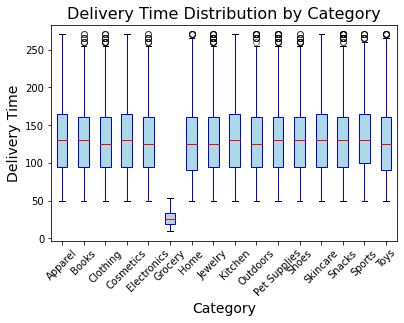

In [8]:
plt.figure(figsize= (20, 12))
processed_df.boxplot(column='Delivery_Time', by='Category', grid=False, patch_artist=True,
             boxprops=dict(facecolor='lightblue', color='blue'),
             whiskerprops=dict(color='blue'),
             medianprops=dict(color='red'),
             flierprops=dict(marker='o', color='orange', alpha=0.5))

plt.title('Delivery Time Distribution by Category', fontsize=16)
plt.suptitle('')  
plt.xlabel('Category', fontsize=14)
plt.ylabel('Delivery Time', fontsize=14)

plt.xticks(rotation=45)
plt.show()

In [9]:
processed_df[['Delivery_Time','Order_Rating']].corr()

,Delivery_Time,Order_Rating
Delivery_Time,1.000000,-0.303724
Order_Rating,-0.303724,1.000000


In [10]:
new_df = processed_df[processed_df['Category'] != 'Grocery']
new_df
new_df[['Delivery_Time','Order_Rating']].corr(method='spearman')

pd.concat([processed_df.iloc[:,1:7],processed_df['Delivery_Time']],axis=1).corr()

,Agent_Age,Order_Rating,Store_Latitude,Store_Longitude,Drop_Latitude,Drop_Longitude,Delivery_Time
Agent_Age,1.000000,-0.117010,0.004068,0.009779,0.004048,0.009748,0.256253
Order_Rating,-0.117010,1.000000,-0.004162,0.005991,-0.004872,0.004877,-0.303724
Store_Latitude,0.004068,-0.004162,1.000000,0.001760,0.999977,0.002246,0.012370
Store_Longitude,0.009779,0.005991,0.001760,1.000000,0.001766,0.999945,0.005232
Drop_Latitude,0.004048,-0.004872,0.999977,0.001766,1.000000,0.002322,0.014226
Drop_Longitude,0.009748,0.004877,0.002246,0.999945,0.002322,1.000000,0.008145
Delivery_Time,0.256253,-0.303724,0.012370,0.005232,0.014226,0.008145,1.000000


In [11]:
processed_df['Delivery_Time'].describe()

count    38781.000000
mean       125.073747
std         51.955841
min         10.000000
25%         90.000000
50%        125.000000
75%        160.000000
max        270.000000
Name: Delivery_Time, dtype: float64

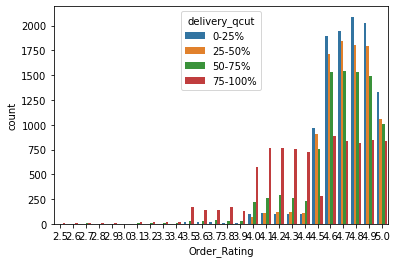

In [12]:
processed_df['delivery_qcut'] = pd.qcut(processed_df['Delivery_Time'], 4, labels=['0-25%', '25-50%', '50-75%', '75-100%'])
ax = sns.countplot(x='Order_Rating',hue='delivery_qcut',data=processed_df)

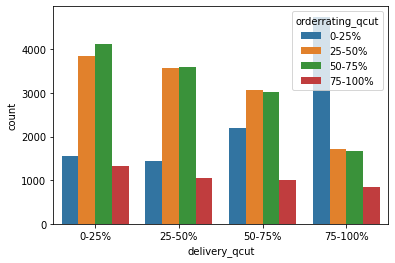

In [13]:
processed_df['orderrating_qcut'] = pd.qcut(processed_df['Order_Rating'], 4, labels=['0-25%', '25-50%', '50-75%', '75-100%'])
ax = sns.countplot(hue='orderrating_qcut',x='delivery_qcut',data=processed_df)

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score
from sklearn import tree

In [16]:
processed_df['distance'] = ((processed_df['Store_Latitude'] - processed_df['Drop_Latitude'])**2 + (processed_df['Store_Longitude'] - processed_df['Drop_Longitude'])**2)**(1/2)
processed_df['Delayed'] = processed_df['Delivery_Time'].apply(lambda x: 1 if x > 150 else 0)
processed_df.drop(columns=['Order_ID','Store_Latitude','Store_Longitude','Drop_Latitude','Drop_Longitude','delivery_qcut','orderrating_qcut','Order_Date','Order_Time','Pickup_Time','Delivery_Time','Category'],axis=1,inplace=True)

modeling_df = processed_df.copy()

In [17]:
x = pd.get_dummies(modeling_df.drop(columns=['Delayed']))
y = modeling_df['Delayed']

In [18]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(27146, 21)
(11635, 21)
(27146,)
(11635,)


In [19]:
model = DecisionTreeClassifier()
model.fit(x_train,y_train)

DecisionTreeClassifier()

In [20]:
y_test_pred = model.predict(x_test)

In [21]:
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.91      0.90      0.91      8438
           1       0.75      0.76      0.76      3197

    accuracy                           0.86     11635
   macro avg       0.83      0.83      0.83     11635
weighted avg       0.87      0.86      0.87     11635



In [22]:
accuracy_score(y_test, y_test_pred)

0.8648904168457241

In [23]:
precision_score(y_test, y_test_pred)

0.7506942301758717

In [24]:
recall_score(y_test,y_test_pred)

0.7610259618392242

In [25]:
x = pd.get_dummies(modeling_df.drop(columns=['Delayed']))
y = modeling_df['Delayed']
model_improved = DecisionTreeClassifier(max_depth=15,min_samples_leaf=10)
model_improved.fit(x_train,y_train)
y_pred_improved = model_improved.predict(x_test)
print(classification_report(y_test,y_pred_improved))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94      8438
           1       0.85      0.81      0.83      3197

    accuracy                           0.91     11635
   macro avg       0.89      0.88      0.88     11635
weighted avg       0.91      0.91      0.91     11635



In [26]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, random_state=45)
clf.fit(x_train, y_train)
y_pred_clf = clf.predict(x_test)
print(classification_report(y_test,y_pred_clf))

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8438
           1       0.81      0.80      0.81      3197

    accuracy                           0.89     11635
   macro avg       0.87      0.87      0.87     11635
weighted avg       0.89      0.89      0.89     11635



In [27]:
#최적의 파마리터 찾기

model = DecisionTreeClassifier(random_state=1)

param_grid = {
    'max_depth': [None, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'auto', 'sqrt', 'log2'],
    'criterion': ['gini', 'entropy']
}

In [28]:
from sklearn.model_selection import GridSearchCV

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

grid_search.fit(x_train, y_train)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)

print(classification_report(y_test,y_pred_clf))

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


c:\Users\sml_0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
540 fits failed out of a total of 2160.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
471 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sml_0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sml_0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py", line 1466, in wrapper
    estimator._validate_params()
  File "c:\Users\sml_0\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\base.py

              precision    recall  f1-score   support

           0       0.93      0.93      0.93      8438
           1       0.81      0.80      0.81      3197

    accuracy                           0.89     11635
   macro avg       0.87      0.87      0.87     11635
weighted avg       0.89      0.89      0.89     11635



In [29]:
#연속형 데이터 스케일링

from sklearn.preprocessing import MinMaxScaler

numeric_df = modeling_df[['Agent_Age','Order_Rating','distance']]
scaler = MinMaxScaler()
df_normalized = scaler.fit_transform(numeric_df)
df_normalized = pd.DataFrame(df_normalized, columns=numeric_df.columns,index=numeric_df.index)
modeling_df[['Agent_Age', 'Order_Rating', 'distance']] = df_normalized


In [30]:
x = pd.get_dummies(modeling_df.drop(columns=['Delayed']))
y = modeling_df['Delayed']
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.3,random_state=1)
model =DecisionTreeClassifier(max_depth=12,min_samples_leaf=15)
model.fit(x_train,y_train)
y_test_pred = model.predict(x_test)
print(classification_report(y_test,y_test_pred))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94      8438
           1       0.84      0.83      0.84      3197

    accuracy                           0.91     11635
   macro avg       0.89      0.89      0.89     11635
weighted avg       0.91      0.91      0.91     11635



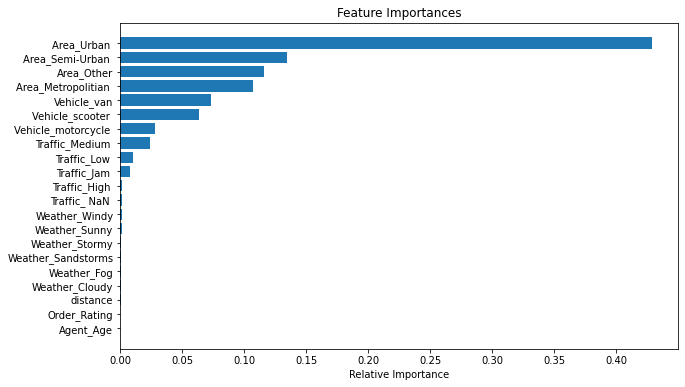

In [31]:
# 스케일링 된 데이터 시각화

importances = model.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(x.shape[1]), importances[indices], align='center')
plt.yticks(range(x.shape[1]), x.columns)
plt.xlabel('Relative Importance')
plt.show()